Warnung: Icon 'delete_icon.png' nicht gefunden. Button wird nur Text anzeigen.


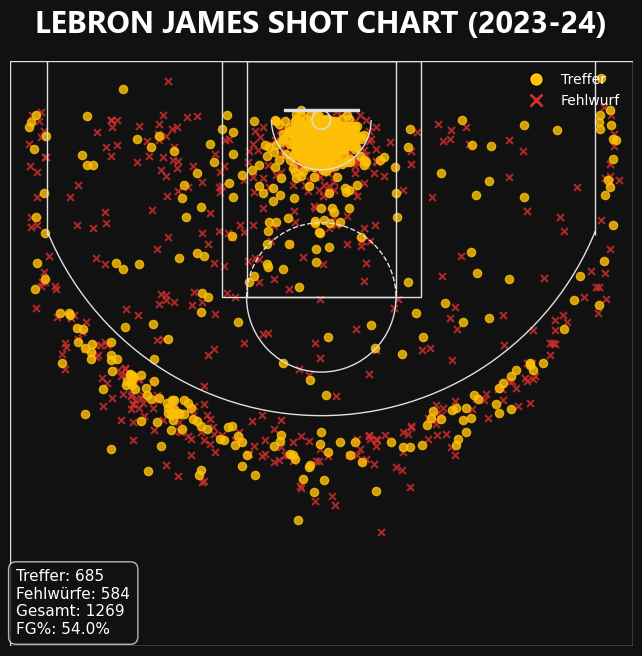

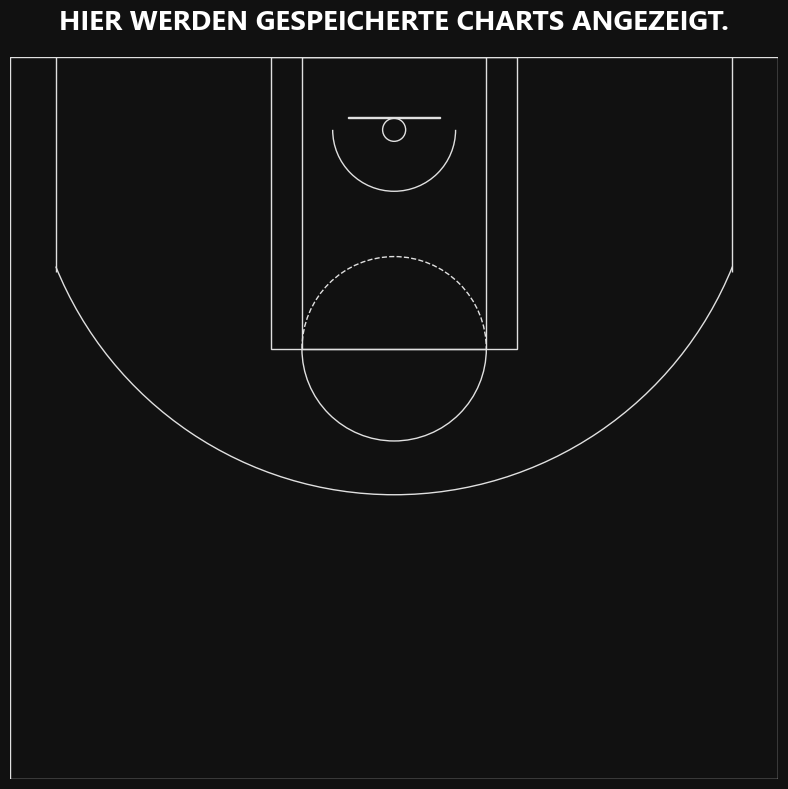

In [13]:
#aktuellste variante
# Imports, unicodedata und os sind neu
import pandas as pd
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.lines import Line2D 
import numpy as np
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
import threading
import time
import json
import unicodedata # Neu für die Namensnormalisierung
import os # Neu für die Verarbeitung von Dateipfaden

try:
    from PIL import Image, ImageTk
except ImportError:
    messagebox.showerror("Fehlende Bibliothek", "Pillow wird benötigt. Installiere es mit: pip install Pillow")
    exit()
import warnings
warnings.filterwarnings('ignore')

# Design-Konstanten (aktualisiert mit neuer Akzentfarbe)
PLOT_BG_COLOR = "#111111"
COURT_LINE_COLOR = "#E0E0E0"
NBA_BLUE = "#051C2D"
NBA_RED = "#CE1141"
NBA_LIGHT_GRAY = "#DDDDDD"
NBA_WHITE = "#FFFFFF"
WIDGET_BG = "#0E2A47"
FONT_FAMILY = "Segoe UI"
NBA_ACCENT_YELLOW = "#FFC72C" # Neue Akzentfarbe

# Court-Funktionen (unverändert)
def draw_court_2d(ax, color=COURT_LINE_COLOR, lw=1.5, outer_lines=True):
    ax.add_patch(Circle((0,0),radius=7.5,linewidth=lw,color=color,fill=False));ax.add_patch(Rectangle((-30,-7.5),60,-1,linewidth=lw,color=color));ax.add_patch(Rectangle((-80,-47.5),160,190,linewidth=lw,color=color,fill=False));ax.add_patch(Rectangle((-60,-47.5),120,190,linewidth=lw,color=color,fill=False));ax.add_patch(Arc((0,142.5),120,120,theta1=0,theta2=180,linewidth=lw,color=color,fill=False));ax.add_patch(Arc((0,142.5),120,120,theta1=180,theta2=360,linewidth=lw,color=color,linestyle='dashed'));ax.add_patch(Arc((0,0),80,80,theta1=0,theta2=180,linewidth=lw,color=color));ax.add_patch(Rectangle((-220,-47.5),0,140,linewidth=lw,color=color));ax.add_patch(Rectangle((220,-47.5),0,140,linewidth=lw,color=color));ax.add_patch(Arc((0,0),475,475,theta1=22,theta2=158,linewidth=lw,color=color))
    if outer_lines: ax.add_patch(Rectangle((-250,-47.5),500,470,linewidth=lw,color=color,fill=False))

# Tooltip Klasse (unverändert)
class ToolTip:
    def __init__(self, widget, text):
        self.widget = widget
        self.text = text
        self.tooltip_window = None
        self.id = None
        self.widget.bind("<Enter>", self.show_tooltip)
        self.widget.bind("<Leave>", self.hide_tooltip)

    def show_tooltip(self, event=None):
        self.cancel_hide()
        self.id = self.widget.after(750, self._show) # Zeigt Tooltip nach 750ms Verzögerung

    def _show(self):
        if self.tooltip_window or not self.widget.winfo_exists():
            return
        
        x = self.widget.winfo_rootx() + 25
        y = self.widget.winfo_rooty() + self.widget.winfo_height() + 5 # Etwas unterhalb des Widgets
        
        self.tooltip_window = tk.Toplevel(self.widget)
        self.tooltip_window.wm_overrideredirect(True) # Keine Fensterrahmen
        self.tooltip_window.wm_geometry(f"+{x}+{y}")
        
        label = tk.Label(self.tooltip_window, text=self.text, background="#FFFFCC", relief="solid", 
                         borderwidth=1, font=(FONT_FAMILY, 9), wraplength=200) # wraplength für Zeilenumbruch
        label.pack(ipadx=1)

    def hide_tooltip(self, event=None):
        if self.id:
            self.widget.after_cancel(self.id)
        if self.tooltip_window:
            self.tooltip_window.destroy()
        self.tooltip_window = None
        self.id = None

    def cancel_hide(self):
        if self.id:
            self.widget.after_cancel(self.id)
            self.id = None

class NBAShotChartApp:
    def __init__(self, root):
        self.root = root; self.root.title("NBA Shot Chart Visualizer"); self.root.geometry("1200x950"); self.root.configure(bg=NBA_BLUE)
        self.all_players = []; self.player_id = None; self.player_name = ""; self.shot_data = pd.DataFrame()
        self.status_text = tk.StringVar(value="Lade Spielerliste...")
        self.player_name_var = tk.StringVar(); self.season_var = tk.StringVar()
        self.saved_charts = {}
        self.suggestion_popup = None
        
        # NEU: Laden der Icons
        self.icons = {}
        self._load_icons()

        self.setup_styles(); self.setup_ui(); self.load_initial_data()

    # NEU: Methode zum Laden der Icons
    def _load_icons(self):
        icon_paths = {
            "search": "search_icon.png", # Beispiel, falls du ein Such-Icon möchtest
            "reset": "reset_icon.png",   # Beispiel
            "save": "save_icon.png",
            "export_image": "export_image_icon.png",
            "export_data": "export_data_icon.png",
            "import_data": "import_data_icon.png",
            "delete": "delete_icon.png",
            "team_import": "team_icon.png",
            "nba_logo": "nba_logo.png" # Das bestehende Logo
        }
        for name, path in icon_paths.items():
            try:
                # Icons für Buttons sind kleiner
                size = (20, 20) if name not in ["nba_logo"] else (35, 80)
                img = Image.open(path).resize(size, Image.LANCZOS)
                self.icons[name] = ImageTk.PhotoImage(img)
            except FileNotFoundError:
                print(f"Warnung: Icon '{path}' nicht gefunden. Button wird nur Text anzeigen.")
                self.icons[name] = None # Setze auf None, wenn nicht gefunden
            except Exception as e:
                print(f"Fehler beim Laden von Icon '{path}': {e}")
                self.icons[name] = None

    def setup_styles(self):
        style=ttk.Style(self.root);style.theme_use('clam');
        
        # Allgemeine Konfiguration
        style.configure('.',background=NBA_BLUE,foreground=NBA_WHITE,font=(FONT_FAMILY,10));
        style.configure('TFrame',background=NBA_BLUE);
        style.configure('TLabel',background=NBA_BLUE,foreground=NBA_WHITE,font=(FONT_FAMILY,10));
        
        # Spezifische Label-Styles (Verbesserte Hierarchie)
        style.configure('Title.TLabel',font=(f"{FONT_FAMILY} Bold",24),foreground=NBA_WHITE); # Größerer Titel
        style.configure('SubTitle.TLabel',font=(f"{FONT_FAMILY} Bold",14),foreground=NBA_WHITE); # Neue Subtitel-Größe
        style.configure('Status.TLabel',foreground=NBA_LIGHT_GRAY,font=(FONT_FAMILY,9));
        
        # Button-Konfiguration (mit Hover-Effekt und Akzentfarbe)
        style.configure('TButton',
                        background=NBA_RED,
                        foreground=NBA_WHITE,
                        font=(f"{FONT_FAMILY} Bold",10),
                        borderwidth=0,
                        padding=(10,5),
                        focusthickness=0, # Entfernt den Fokus-Rahmen
                        relief='flat' # Flacher Button-Stil
                        );
        style.map('TButton',
                  background=[('active','#E43D68'), # Rötlicher beim Hover
                              ('disabled','#555555')],
                  foreground=[('disabled','#AAAAAA'),
                              ('focus', NBA_ACCENT_YELLOW)], # Akzentfarbe beim Fokus
                  relief=[('pressed', 'groove'), # Leichter 3D-Effekt beim Drücken
                          ('!pressed', 'flat')]
                  );
        
        # Entry und Combobox
        style.configure('TEntry',
                        fieldbackground=WIDGET_BG,
                        foreground=NBA_WHITE,
                        bordercolor=NBA_LIGHT_GRAY,
                        insertcolor=NBA_WHITE,
                        padding=(5,5) # Etwas mehr Polsterung
                        );
        style.map('TEntry',
                  bordercolor=[('focus', NBA_ACCENT_YELLOW)] # Akzentfarbe beim Fokus
                  );

        style.configure('TCombobox',
                        fieldbackground=WIDGET_BG,
                        foreground=NBA_WHITE,
                        bordercolor=NBA_LIGHT_GRAY,
                        arrowcolor=NBA_WHITE,
                        selectbackground=WIDGET_BG,
                        selectforeground=NBA_WHITE,
                        padding=(5,5) # Etwas mehr Polsterung
                        );
        self.root.option_add('*TCombobox*Listbox.background',WIDGET_BG);
        self.root.option_add('*TCombobox*Listbox.foreground',NBA_WHITE);
        self.root.option_add('*TCombobox*Listbox.font',(FONT_FAMILY,10)); # Schriftart für Dropdown-Liste

        # Notebook (Tabs)
        style.configure('TNotebook',background=NBA_BLUE,borderwidth=0);
        style.configure('TNotebook.Tab',background=WIDGET_BG,foreground=NBA_LIGHT_GRAY,padding=[15,8],font=(FONT_FAMILY,11,'bold'),borderwidth=0);
        style.map('TNotebook.Tab',background=[('selected',NBA_BLUE)],foreground=[('selected',NBA_WHITE)],
                  expand=[('selected', [0,0,0,0])] # Entfernt den leichten Rand des ausgewählten Tabs
                  )
        
        # Listbox für gespeicherte Charts
        style.configure('TListbox',
                        background=WIDGET_BG,
                        foreground=NBA_WHITE,
                        selectbackground=NBA_RED,
                        selectforeground=NBA_WHITE,
                        font=(FONT_FAMILY,10),
                        borderwidth=0,
                        highlightthickness=1, # Leichter Rahmen beim Fokus
                        highlightbackground=NBA_ACCENT_YELLOW, # Akzentfarbe für Fokus
                        relief='flat'
                        )
        style.map('TListbox',
                  background=[('selected', NBA_RED)],
                  foreground=[('selected', NBA_WHITE)]
                  )

    def setup_ui(self):
        header_frame=ttk.Frame(self.root,padding=(10,10));header_frame.pack(fill=tk.X);
        
        # NBA Logo einbinden
        if self.icons["nba_logo"]:
            ttk.Label(header_frame,image=self.icons["nba_logo"]).pack(side=tk.LEFT,padx=(0,10))
        else:
            print("NBA Logo konnte nicht geladen werden.") # Fallback, falls das Logo fehlt
        
        ttk.Label(header_frame,text="NBA SHOT CHART VISUALIZER",style='Title.TLabel').pack(side=tk.LEFT,pady=10)
        self.notebook=ttk.Notebook(self.root,style='TNotebook');self.notebook.pack(expand=True,fill='both',padx=10,pady=5)
        tab1_frame=ttk.Frame(self.notebook,padding=10);tab2_frame=ttk.Frame(self.notebook,padding=10)
        self.notebook.add(tab1_frame,text='Live Suche');self.notebook.add(tab2_frame,text='Gespeicherte Charts')
        self._setup_tab1(tab1_frame);self._setup_tab2(tab2_frame)
        status_bar=ttk.Label(self.root,textvariable=self.status_text,style='Status.TLabel',padding=5);status_bar.pack(side=tk.BOTTOM,fill=tk.X)

    def _setup_tab1(self, parent_frame):
        controls_frame = ttk.Frame(parent_frame); controls_frame.pack(fill=tk.X, pady=(0, 10))
        controls_frame.grid_columnconfigure(0, weight=1); controls_frame.grid_columnconfigure(1, weight=1)
        search_frame = ttk.Frame(controls_frame); search_frame.grid(row=0, column=0, sticky="nsew", padx=(0, 20))
        ttk.Label(search_frame, text="Spielername:", font=(FONT_FAMILY, 11, 'bold')).pack(anchor="w")
        self.player_name_entry = ttk.Entry(search_frame, textvariable=self.player_name_var, width=40, font=(FONT_FAMILY, 11)); self.player_name_entry.pack(fill=tk.X, pady=(5, 0)); self.player_name_entry.config(state="disabled")
        self.player_name_entry.bind("<KeyRelease>", self._on_key_release)
        self.player_name_entry.bind("<FocusOut>", self._hide_suggestion_popup_delayed)
        ToolTip(self.player_name_entry, "Geben Sie den Namen eines NBA-Spielers ein.")

        actions_frame = ttk.Frame(controls_frame); actions_frame.grid(row=0, column=1, sticky="nsew")
        season_frame = ttk.Frame(actions_frame); season_frame.pack(anchor="w", fill=tk.X)
        ttk.Label(season_frame, text="Saison:").pack(side=tk.LEFT, padx=(0, 10)); current_year = int(time.strftime("%Y")); seasons = [f"{y}-{str(y+1)[-2:]}" for y in range(current_year, 1995, -1)]; self.season_var.set(seasons[0])
        self.season_dropdown = ttk.Combobox(season_frame, textvariable=self.season_var, values=seasons, state="readonly", width=10); self.season_dropdown.pack(side=tk.LEFT)
        ToolTip(self.season_dropdown, "Wählen Sie die Saison aus, für die Wurfdaten angezeigt werden sollen.")

        buttons_frame = ttk.Frame(actions_frame); buttons_frame.pack(anchor="w", fill=tk.X, pady=10)
        
        # Buttons mit Icons
        self.search_button = ttk.Button(buttons_frame, text="Suchen", command=self.start_search_thread,
                                        image=self.icons["search"] if self.icons["search"] else None, compound=tk.LEFT); 
        self.search_button.pack(side=tk.LEFT, padx=(0, 5)); self.search_button.config(state="disabled")
        ToolTip(self.search_button, "Startet die Suche nach Wurfdaten für den ausgewählten Spieler und die Saison.")

        reset_button = ttk.Button(buttons_frame, text="Zurücksetzen", command=self._reset_application_state,
                                  image=self.icons["reset"] if self.icons["reset"] else None, compound=tk.LEFT); 
        reset_button.pack(side=tk.LEFT, padx=5)
        ToolTip(reset_button, "Setzt die aktuelle Suche zurück und leert die Eingabefelder.")

        save_button = ttk.Button(buttons_frame, text="Chart speichern", command=self._save_current_chart,
                                 image=self.icons["save"] if self.icons["save"] else None, compound=tk.LEFT); 
        save_button.pack(side=tk.LEFT, padx=5)
        ToolTip(save_button, "Speichert das aktuell angezeigte Chart in den 'Gespeicherten Charts'.")

        ttk.Separator(parent_frame, orient=tk.HORIZONTAL).pack(fill=tk.X, pady=15)
        io_frame = ttk.Frame(parent_frame); io_frame.pack(fill=tk.X)
        
        export_image_button = ttk.Button(io_frame, text="Bild exportieren", command=self._export_heatmap_as_image,
                                         image=self.icons["export_image"] if self.icons["export_image"] else None, compound=tk.LEFT); 
        export_image_button.pack(side=tk.LEFT, padx=(0, 5))
        ToolTip(export_image_button, "Exportiert das aktuelle Chart als Bilddatei (PNG/JPG).")

        export_data_button = ttk.Button(io_frame, text="Daten exportieren", command=self._export_data_as_json,
                                        image=self.icons["export_data"] if self.icons["export_data"] else None, compound=tk.LEFT); 
        export_data_button.pack(side=tk.LEFT, padx=5)
        ToolTip(export_data_button, "Exportiert die Wurfdaten des aktuellen Charts als JSON-Datei.")

        import_data_button = ttk.Button(io_frame, text="Daten importieren", command=self._import_data_from_json,
                                        image=self.icons["import_data"] if self.icons["import_data"] else None, compound=tk.LEFT); 
        import_data_button.pack(side=tk.LEFT, padx=5)
        ToolTip(import_data_button, "Importiert Wurfdaten aus einer JSON-Datei.")

        import_team_button = ttk.Button(io_frame, text="Team aus JSON laden", command=self._import_team_from_json,
                                        image=self.icons["team_import"] if self.icons["team_import"] else None, compound=tk.LEFT); 
        import_team_button.pack(side=tk.LEFT, padx=5)
        ToolTip(import_team_button, "Lädt Wurfdaten für mehrere Spieler aus einer JSON-Datei (Team-Analyse).")

        self.fig1, _ = plt.subplots(facecolor=PLOT_BG_COLOR); self.canvas1 = FigureCanvasTkAgg(self.fig1, master=parent_frame); self.canvas1_widget = self.canvas1.get_tk_widget(); self.canvas1_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True, pady=(15, 0))
        self._draw_empty_court(self.fig1, "Geben Sie einen Spielernamen ein.")
        
    def normalize_name(self, name):
        return unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('ascii')

    def _create_or_update_suggestion_popup(self, suggestions):
        if not self.suggestion_popup:
            # Platzierung des Popups direkt unter dem Entry-Feld
            x = self.player_name_entry.winfo_rootx()
            y = self.player_name_entry.winfo_rooty() + self.player_name_entry.winfo_height()
            
            self.suggestion_popup = tk.Toplevel(self.root)
            self.suggestion_popup.overrideredirect(True)
            self.suggestion_popup.geometry(f"{self.player_name_entry.winfo_width()}x250+{x}+{y}") # Breite an Entry anpassen
            
            # Verwende ttk.Listbox für konsistentes Styling
            listbox = tk.Listbox(self.suggestion_popup, height=10, bg=WIDGET_BG, fg=NBA_WHITE, 
                                 highlightthickness=1, highlightbackground=NBA_RED, 
                                 borderwidth=0, relief=tk.FLAT, font=(FONT_FAMILY, 11),
                                 selectbackground=NBA_RED, selectforeground=NBA_WHITE) # Konsistente Auswahlfarben
            listbox.pack(expand=True, fill='both')
            listbox.bind("<ButtonRelease-1>", self._on_suggestion_select)
            listbox.bind("<Return>", self._on_suggestion_select)
            self.suggestion_popup.listbox = listbox
        
        listbox = self.suggestion_popup.listbox
        listbox.delete(0, tk.END)
        for suggestion in suggestions: listbox.insert(tk.END, suggestion)

    def _hide_suggestion_popup(self):
        if self.suggestion_popup: self.suggestion_popup.destroy(); self.suggestion_popup = None

    def _hide_suggestion_popup_delayed(self, event=None):
        self.root.after(200, self._hide_suggestion_popup)

    def _on_key_release(self, event):
        if event.keysym in ("Up", "Down", "Left", "Right", "Shift_L", "Shift_R", "Control_L", "Control_R", "Alt_L", "Alt_R"): return
        typed_text = self.player_name_var.get().strip().lower()
        if not typed_text: self._hide_suggestion_popup(); return
        normalized_typed_text = self.normalize_name(typed_text)
        suggestions = [p['full_name'] for p in self.all_players if self.normalize_name(p['full_name']).lower().startswith(normalized_typed_text)]
        if suggestions: self._create_or_update_suggestion_popup(suggestions[:10])
        else: self._hide_suggestion_popup()

    def _on_suggestion_select(self, event):
        if not self.suggestion_popup: return
        listbox = self.suggestion_popup.listbox; selection_indices = listbox.curselection()
        if not selection_indices:
            if hasattr(event, 'keysym') and event.keysym == 'Return': self.start_search_thread()
            return
        selected_player = listbox.get(selection_indices[0]); self.player_name_var.set(selected_player)
        self._hide_suggestion_popup(); self.player_name_entry.focus(); self.start_search_thread()

    def _load_players_worker(self):
        try:
            self.all_players = players.get_players()
            self.status_text.set(f"Bereit. {len(self.all_players)} Spieler geladen.")
            self.player_name_entry.config(state="normal"); self.search_button.config(state="normal")
        except Exception as e:
            self.status_text.set("Fehler beim Laden der Spielerliste."); messagebox.showerror("API Fehler", f"Spielerliste nicht ladbar: {e}")

    def _import_team_from_json(self):
        filepath = filedialog.askopenfilename(filetypes=[("JSON-Dateien", "*.json")], title="Team-JSON importieren...")
        if not filepath: self.status_text.set("Team-Import abgebrochen."); return
        try:
            with open(filepath, 'r', encoding='utf-8') as f: player_list = json.load(f)
            if not isinstance(player_list, list): messagebox.showerror("Importfehler", "Die JSON-Datei muss eine Liste von Spielernamen enthalten."); return
            team_name = os.path.basename(filepath).split('.')[0].replace('_', ' ').replace('-', ' ')
            self.status_text.set(f"Lade Team-Daten für '{team_name}'...")
            self.search_button.config(state="disabled")
            threading.Thread(target=self._fetch_team_data_worker, args=(player_list, team_name), daemon=True).start()
        except Exception as e:
            messagebox.showerror("Importfehler", f"Fehler beim Lesen der JSON-Datei: {e}"); self.status_text.set("Team-Import fehlgeschlagen.")

    def _fetch_team_data_worker(self, player_list, team_name):
        player_data_map = {}
        not_found_players = []
        season = self.season_var.get()
        for i, player_name in enumerate(player_list):
            self.root.after(0, self.status_text.set, f"Lade Daten ({i+1}/{len(player_list)}): {player_name}...")
            player_id = self._get_player_id(player_name)
            if player_id is None:
                not_found_players.append(player_name); continue
            try:
                shot_data = self._get_player_shot_data(player_id, season)
                if not shot_data.empty: player_data_map[player_name] = shot_data
            except Exception as e: print(f"Fehler beim Laden der Wurfdaten für {player_name}: {e}")
        self.root.after(0, self._handle_team_charts_loaded, player_data_map, not_found_players, team_name)

    def _handle_team_charts_loaded(self, player_data_map, not_found_players, team_name):
        if not_found_players:
            messagebox.showwarning("Spieler nicht gefunden", f"Die folgenden Spieler wurden nicht gefunden und übersprungen:\n\n" + "\n".join(not_found_players))
        
        season = self.season_var.get()
        saved_count = 0
        
        # 1. Einzelne Spieler-Charts speichern
        for player_name, shot_data in player_data_map.items():
            chart_key = f"{player_name} ({season})"
            if chart_key in self.saved_charts: continue
            chart_data = {"player_name": player_name, "season": season, "shot_data": shot_data.copy()}
            self.saved_charts[chart_key] = chart_data
            self.saved_charts_listbox.insert(tk.END, chart_key)
            saved_count += 1

        # 2. Kombinierten Chart erstellen und speichern
        last_saved_key = None
        if player_data_map:
            combined_df = pd.concat(player_data_map.values(), ignore_index=True)
            if not combined_df.empty:
                combined_name = f"{team_name} (Kombiniert)"
                chart_key = f"{combined_name} ({season})"
                if chart_key not in self.saved_charts:
                    chart_data = {"player_name": combined_name, "season": season, "shot_data": combined_df}
                    self.saved_charts[chart_key] = chart_data
                    self.saved_charts_listbox.insert(tk.END, chart_key)
                    saved_count += 1
                    last_saved_key = chart_key

        self._draw_empty_court(self.fig1, "Team-Analyse abgeschlossen."); self.canvas1.draw()
        self.player_name_var.set("")
        
        if saved_count > 0:
            self.status_text.set(f"{saved_count} Chart(s) wurden gespeichert.")
            self.notebook.select(1)
            # Den zuletzt hinzugefügten (kombinierten) Chart auswählen und anzeigen
            final_index_to_select = self.saved_charts_listbox.size() - 1
            self.saved_charts_listbox.selection_set(final_index_to_select)
            self.saved_charts_listbox.activate(final_index_to_select)
            self.saved_charts_listbox.see(final_index_to_select)
            self._on_saved_chart_select(None)
        else:
            self.status_text.set("Keine neuen Charts zum Speichern gefunden.")
            
        self.search_button.config(state="normal")

    def _setup_tab2(self, parent_frame):
        tab2_left_pane=ttk.Frame(parent_frame,width=250);tab2_left_pane.pack(side=tk.LEFT,fill=tk.Y,padx=(0,10));tab2_right_pane=ttk.Frame(parent_frame);tab2_right_pane.pack(side=tk.RIGHT,fill=tk.BOTH,expand=True);
        
        list_label=ttk.Label(tab2_left_pane,text="Gespeicherte Analysen",style='SubTitle.TLabel'); # Angenommener neuer Style
        list_label.pack(anchor=tk.W,pady=(0,5));
        
        # Verwende den TListbox Style
        self.saved_charts_listbox=tk.Listbox(tab2_left_pane,
                                            bg=WIDGET_BG,
                                            fg=NBA_WHITE,
                                            highlightthickness=1, # Rahmen für Fokus
                                            highlightbackground=NBA_ACCENT_YELLOW, # Akzentfarbe für Fokus
                                            borderwidth=0, # Keine Standard-Border
                                            relief=tk.FLAT,
                                            font=(FONT_FAMILY,10),
                                            selectbackground=NBA_RED, # Auswahlfarbe
                                            selectforeground=NBA_WHITE # Auswahltextfarbe
                                            );
        self.saved_charts_listbox.pack(fill=tk.BOTH,expand=True);
        self.saved_charts_listbox.bind("<<ListboxSelect>>",self._on_saved_chart_select);
        
        delete_button=ttk.Button(tab2_left_pane,text="Auswahl entfernen",command=self._delete_saved_chart,
                                 image=self.icons["delete"] if self.icons["delete"] else None, compound=tk.LEFT);
        delete_button.pack(fill=tk.X,pady=(10,0))
        ToolTip(delete_button, "Entfernt das ausgewählte Chart aus der Liste der gespeicherten Analysen.")

        self.fig2, _ = plt.subplots(facecolor=PLOT_BG_COLOR);self.canvas2=FigureCanvasTkAgg(self.fig2,master=tab2_right_pane);self.canvas2_widget=self.canvas2.get_tk_widget();self.canvas2_widget.pack(fill=tk.BOTH,expand=True)
        self._draw_empty_court(self.fig2, "Hier werden gespeicherte Charts angezeigt.")

    def _draw_empty_court(self, fig, title):
        fig.clf();ax=fig.add_subplot(1,1,1);ax.set_facecolor(PLOT_BG_COLOR);draw_court_2d(ax,color=COURT_LINE_COLOR,lw=1);ax.set_title(title.upper(),fontsize=20,color=NBA_WHITE,fontfamily=FONT_FAMILY,fontweight='bold',pad=20);ax.set_xlim(-250,250);ax.set_ylim(422.5,-47.5);ax.set_aspect('equal',adjustable='box');ax.axis('off');fig.tight_layout(pad=0)

    def _plot_makes_misses_chart(self, fig, player_name, season, shot_data):
        fig.clf();ax=fig.add_subplot(1,1,1);ax.set_facecolor(PLOT_BG_COLOR)
        makes=shot_data[shot_data['SHOT_MADE_FLAG']==1]
        misses=shot_data[shot_data['SHOT_MADE_FLAG']==0]
        ax.scatter(misses['LOC_X'],misses['LOC_Y'],marker='x',c='#D32F2F',s=25,alpha=0.8,label='Fehlwurf')
        ax.scatter(makes['LOC_X'],makes['LOC_Y'],marker='o',c='#FFC107',s=35,alpha=0.8,label='Treffer')
        draw_court_2d(ax,color=COURT_LINE_COLOR,lw=1)
        ax.set_title(f"{player_name.upper()} SHOT CHART ({season})",fontsize=22,color=NBA_WHITE,fontfamily=FONT_FAMILY,fontweight='bold',pad=20)
        ax.set_xlim(-250,250);ax.set_ylim(422.5,-47.5);ax.set_aspect('equal',adjustable='box');ax.axis('off')
        legend_elements=[Line2D([0],[0],marker='o',color='None',label='Treffer',markerfacecolor='#FFC107',markersize=10),Line2D([0],[0],marker='x',color='#D32F2F',label='Fehlwurf',markersize=8,linestyle='None',markeredgewidth=2)]
        ax.legend(handles=legend_elements,loc='upper right',labelcolor='white',frameon=False,fontsize=10)
        
        # Statistik für Treffer und Fehlwürfe hinzufügen, inklusive FG%
        makes_count = len(makes)
        misses_count = len(misses)
        total_shots = len(shot_data)
        
        if total_shots > 0:
            fg_percent = (makes_count / total_shots) * 100
            stats_text = f"Treffer: {makes_count}\nFehlwürfe: {misses_count}\nGesamt: {total_shots}\nFG%: {fg_percent:.1f}%"
        else:
            stats_text = f"Treffer: {makes_count}\nFehlwürfe: {misses_count}\nGesamt: {total_shots}\nFG%: N/A"

        # Positionierung der Statistik links unten im Court-Bereich
        ax.text(-245, 415, stats_text, color=NBA_WHITE, fontsize=11, ha='left', va='bottom', 
                bbox=dict(boxstyle='round,pad=0.5', fc=PLOT_BG_COLOR, ec=COURT_LINE_COLOR, alpha=0.8))

        fig.tight_layout(pad=0)

    def update_plot(self):
        if self.shot_data.empty:
            if self.player_name:self._draw_empty_court(self.fig1,f"Keine Daten für {self.player_name} ({self.season_var.get()}).")
            else:self._draw_empty_court(self.fig1,"Bitte suchen oder importieren Sie Daten.")
        else:self._plot_makes_misses_chart(self.fig1,self.player_name,self.season_var.get(),self.shot_data)
        self.canvas1.draw()

    def _on_saved_chart_select(self, event):
        selection_indices=self.saved_charts_listbox.curselection()
        if not selection_indices:return
        selected_key=self.saved_charts_listbox.get(selection_indices[0]);chart_data=self.saved_charts.get(selected_key)
        if chart_data:self._plot_makes_misses_chart(self.fig2,chart_data['player_name'],chart_data['season'],chart_data['shot_data']);self.canvas2.draw()

    def _save_current_chart(self):
        if self.shot_data.empty:messagebox.showinfo("Speichern nicht möglich","Keine Daten zum Speichern.");return
        chart_key=f"{self.player_name} ({self.season_var.get()})";
        if chart_key in self.saved_charts:messagebox.showinfo("Bereits vorhanden","Diese Analyse wurde bereits gespeichert.");return
        chart_data={"player_name":self.player_name,"season":self.season_var.get(),"shot_data":self.shot_data.copy()};self.saved_charts[chart_key]=chart_data;self.saved_charts_listbox.insert(tk.END,chart_key);self.notebook.select(1)

    def _delete_saved_chart(self):
        selection_indices=self.saved_charts_listbox.curselection()
        if not selection_indices:messagebox.showwarning("Keine Auswahl","Bitte Eintrag zum Entfernen auswählen.");return
        selected_key=self.saved_charts_listbox.get(selection_indices[0]);
        
        # Bestätigungsdialog vor dem Löschen
        if messagebox.askyesno("Chart löschen", f"Möchtest du '{selected_key}' wirklich löschen?"):
            del self.saved_charts[selected_key]
            self.saved_charts_listbox.delete(selection_indices[0])
            self._draw_empty_court(self.fig2,"Hier werden gespeicherte Charts angezeigt.")
            self.canvas2.draw()
            self.status_text.set(f"'{selected_key}' wurde entfernt.")
        else:
            self.status_text.set("Löschen abgebrochen.")

    def _reset_application_state(self):
        self.player_id=None;self.player_name="";self.shot_data=pd.DataFrame();self.player_name_var.set("");self._hide_suggestion_popup();self._draw_empty_court(self.fig1,"Geben Sie einen Spielernamen ein.");self.canvas1.draw();self.status_text.set("Suche zurückgesetzt. Bereit für eine neue Eingabe.");self.player_name_entry.focus_set()

    def _export_heatmap_as_image(self):
        active_tab_index=self.notebook.index(self.notebook.select())
        if active_tab_index==0:
            if self.shot_data.empty or not self.player_name:messagebox.showinfo("Export nicht möglich","Keine Heatmap zum Exportieren vorhanden.");return
            fig_to_save,player_name,season=self.fig1,self.player_name,self.season_var.get()
        else:
            selection_indices=self.saved_charts_listbox.curselection()
            if not selection_indices:messagebox.showinfo("Export nicht möglich","Bitte wählen Sie ein gespeichertes Chart zum Exportieren aus.");return
            selected_key=self.saved_charts_listbox.get(selection_indices[0]);chart_data=self.saved_charts.get(selected_key);fig_to_save,player_name,season=self.fig2,chart_data['player_name'],chart_data['season']
        filepath=filedialog.asksaveasfilename(defaultextension=".png",filetypes=[("PNG-Bild","*.png"),("JPEG-Bild","*.jpg")],initialfile=f"{player_name.replace(' ','_')}_{season}.png",title="Heatmap als Bild speichern...")
        if not filepath:self.status_text.set("Bild-Export abgebrochen.");return
        try:fig_to_save.savefig(filepath,dpi=300,bbox_inches='tight',facecolor=PLOT_BG_COLOR);self.status_text.set(f"Bild erfolgreich exportiert.")
        except Exception as e:messagebox.showerror("Exportfehler",f"Fehler: {e}")

    def _export_data_as_json(self):
        if self.shot_data.empty:messagebox.showinfo("Export nicht möglich","Keine Daten zum Exportieren vorhanden.");return
        filepath=filedialog.asksaveasfilename(defaultextension=".json",filetypes=[("JSON-Dateien","*.json")],initialfile=f"{self.player_name.replace(' ','_')}_{self.season_var.get()}_shotdata.json",title="Wurfdaten speichern...")
        if not filepath:self.status_text.set("Daten-Export abgebrochen.");return
        try:
            with open(filepath,'w') as f:json.dump({"player_name":self.player_name,"season":self.season_var.get(),"shot_data":self.shot_data.to_dict('records')},f,indent=4)
            self.status_text.set(f"Daten erfolgreich exportiert.")
        except Exception as e:messagebox.showerror("Exportfehler",f"Fehler: {e}")

    def _import_data_from_json(self):
        filepath=filedialog.askopenfilename(filetypes=[("JSON-Dateien","*.json")],title="Wurfdaten importieren...")
        if not filepath:self.status_text.set("Daten-Import abgebrochen.");return
        try:
            with open(filepath,'r') as f:data=json.load(f)
            if "player_name" in data and "shot_data" in data and "season" in data:
                self.player_name=data["player_name"];self.shot_data=pd.DataFrame(data["shot_data"]);self.season_var.set(data["season"]);self.player_name_var.set(self.player_name);self.player_id=-1
                self.update_plot();self.status_text.set(f"Daten für {self.player_name} importiert.")
            else: messagebox.showerror("Importfehler", "Die JSON-Datei hat nicht das erwartete Format für Einzelspieler-Wurfdaten.")
        except Exception as e:messagebox.showerror("Importfehler",f"Fehler: {e}")

    def load_initial_data(self):threading.Thread(target=self._load_players_worker,daemon=True).start()

    def start_search_thread(self,event=None):
        self._hide_suggestion_popup();self.player_name=self.player_name_var.get().strip()
        if not self.player_name:messagebox.showwarning("Eingabefehler","Bitte Namen eingeben.");return
        self.status_text.set(f"Suche nach '{self.player_name}'...");self.search_button.config(state="disabled");threading.Thread(target=self._fetch_data_worker,daemon=True).start()

    def _fetch_data_worker(self):
        player_id=self._get_player_id(self.player_name)
        if player_id is None:self.root.after(0,self._handle_player_not_found);return
        self.player_id=player_id;season=self.season_var.get();self.status_text.set(f"Lade Wurfdaten für {self.player_name} ({season})...")
        try:self.shot_data=self._get_player_shot_data(player_id,season);self.root.after(0,self.update_plot)
        except Exception as e:self.root.after(0,lambda:messagebox.showerror("API Fehler",str(e)))
        finally:
            self.root.after(0,lambda:self.search_button.config(state="normal"))
            self.root.after(0,lambda:self.status_text.set(f"Daten für {self.player_name} geladen. Bereit."))

    def _get_player_id(self,name):p=[p for p in self.all_players if p['full_name'].lower()==name.lower()];return p[0]['id'] if p else None

    def _get_player_shot_data(self,pid,season):
        try:df=shotchartdetail.ShotChartDetail(team_id=0,player_id=pid,context_measure_simple='FGA',season_nullable=season,season_type_all_star='Regular Season').get_data_frames()[0];return df[['LOC_X','LOC_Y','SHOT_MADE_FLAG']]
        except Exception as e:raise ConnectionError(f"Fehler bei Wurfdaten: {e}")


    def _handle_player_not_found(self):
        messagebox.showerror("Spieler nicht gefunden",f"Spieler '{self.player_name}' nicht gefunden.");self._draw_empty_court(self.fig1,f"Spieler '{self.player_name}' nicht gefunden.");self.search_button.config(state="normal");self.status_text.set("Bereit.");self.canvas1.draw()
        
if __name__ == "__main__":
    root = tk.Tk()
    app = NBAShotChartApp(root)
    root.mainloop()